# Feature Engineering and Modelling

In [1]:
!pip3 install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# libraries importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
date_cols=['date_activ','date_end','date_modif_prod','date_renewal']
df = pd.read_csv(r'./clean_data_modeling.csv',parse_dates=date_cols)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_off_peak_var,mean_3m_price_peak_var,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_med_peak,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0


In [4]:
df.drop(columns = 'Unnamed: 0', inplace=True)

In [5]:
df.shape

(14605, 53)

In [6]:
df.dtypes

id                                        object
channel_sales                             object
cons_12m                                   int64
cons_gas_12m                               int64
cons_last_month                            int64
date_activ                        datetime64[ns]
date_end                          datetime64[ns]
date_modif_prod                   datetime64[ns]
date_renewal                      datetime64[ns]
forecast_cons_12m                        float64
forecast_cons_year                         int64
forecast_discount_energy                 float64
forecast_meter_rent_12m                  float64
forecast_price_energy_off_peak           float64
forecast_price_energy_peak               float64
forecast_price_pow_off_peak              float64
has_gas                                   object
imp_cons                                 float64
margin_gross_pow_ele                     float64
margin_net_pow_ele                       float64
nb_prod_act         

# Feature Engineering

In [7]:
price_df = pd.read_csv(r'C:\Users\risha\OneDrive\Desktop\Datasets\BCG data set/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [8]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id','price_date']).agg({'price_off_peak_var':'mean','price_off_peak_fix':'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [9]:
monthly_price_by_id.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885


In [10]:
jan_prices.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0004351ebdd665e6ee664792efc4fd13,2015-01-01,0.148047,44.266931
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-01-01,0.150837,44.444710
3,0010ee3855fdea87602a5b7aba8e42de,2015-01-01,0.123086,40.565969
4,00114d74e963e47177db89bc70108537,2015-01-01,0.149434,44.266931


In [11]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_med_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


In [12]:
# We no longer need the datetime columns so we can drop them

remove = ['date_activ','date_end','date_modif_prod','date_renewal']

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_med_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


# Transform Categorical Data

In [13]:
#For the column has_gas, replace t for 1 and f for 0
df['has_gas']=df['has_gas'].replace(['t','f'],[1,0])

In [14]:
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [15]:
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [16]:
#One hot encoding using get_dummies()
df = pd.get_dummies(df, columns = ['channel_sales', 'origin_up'])

In [17]:
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_MISSING,origin_up_ewxeelcelemmiwuafmddpobolfuxioce,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,origin_up_usapbepcfoloekilkwsdiboslwaxobdp
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,1,0,0,0,0,0,0,0,1,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,1,0,0,0,0,0,1,0,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,0,1,0,0,0,0,1,0,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,0,0,0,0,0,0,1,0,0,0


In [18]:
#remove values with very little occurences
df = df.drop(columns=['channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu','channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
                     'origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])

In [19]:
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,0.020057,3.700961,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,-0.003767,0.177779,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,-0.004670,0.177779,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,-0.004547,0.177779,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,-0.006192,0.162916,1,0,0,0,0,1,0,0


# Tranform Numeric Data

In [20]:
numeric_features = df[[
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]]
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14605.0,159230.267032,573483.629064,0.0,5674.000000,14116.000000,40764.000000,6.207104e+06
cons_gas_12m,14605.0,28091.082506,162978.563803,0.0,0.000000,0.000000,0.000000,4.154590e+06
cons_last_month,14605.0,16091.371448,64366.262314,0.0,0.000000,793.000000,3383.000000,7.712030e+05
forecast_cons_12m,14605.0,1868.638618,2387.651549,0.0,494.980000,1112.610000,2402.270000,8.290283e+04
forecast_cons_year,14605.0,1399.858747,3247.876793,0.0,0.000000,314.000000,1746.000000,1.753750e+05
forecast_discount_energy,14605.0,0.966450,5.108355,0.0,0.000000,0.000000,0.000000,3.000000e+01
forecast_meter_rent_12m,14605.0,63.090448,66.166636,0.0,16.180000,18.800000,131.030000,5.993100e+02
forecast_price_energy_off_peak,14605.0,0.137282,0.024623,0.0,0.116340,0.143166,0.146348,2.739630e-01
forecast_price_energy_peak,14605.0,0.050488,0.049037,0.0,0.000000,0.084138,0.098837,1.959750e-01
forecast_price_pow_off_peak,14605.0,43.130085,4.486140,0.0,40.606701,44.311378,44.311378,5.926638e+01


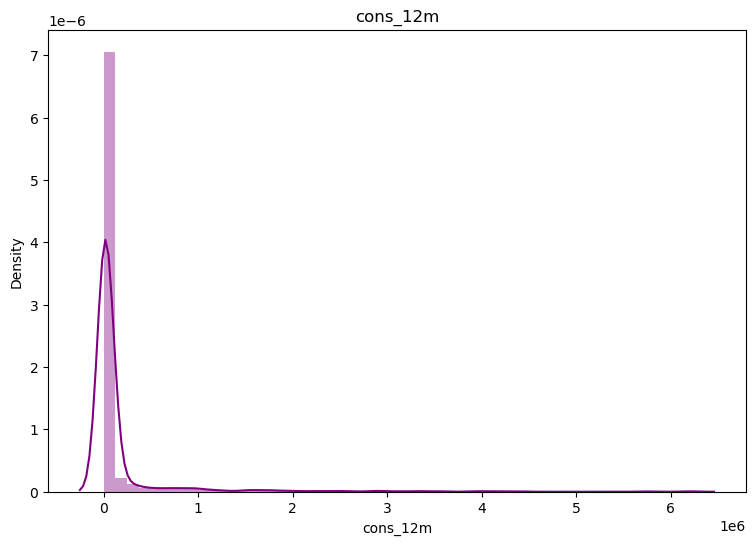

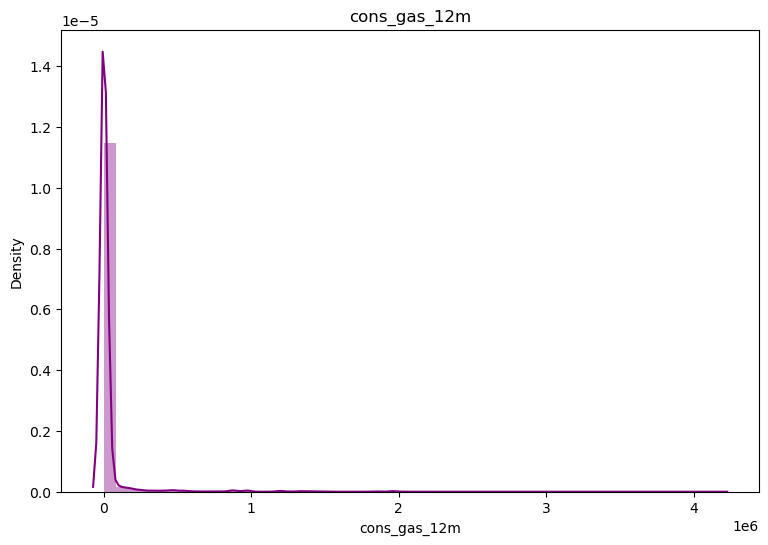

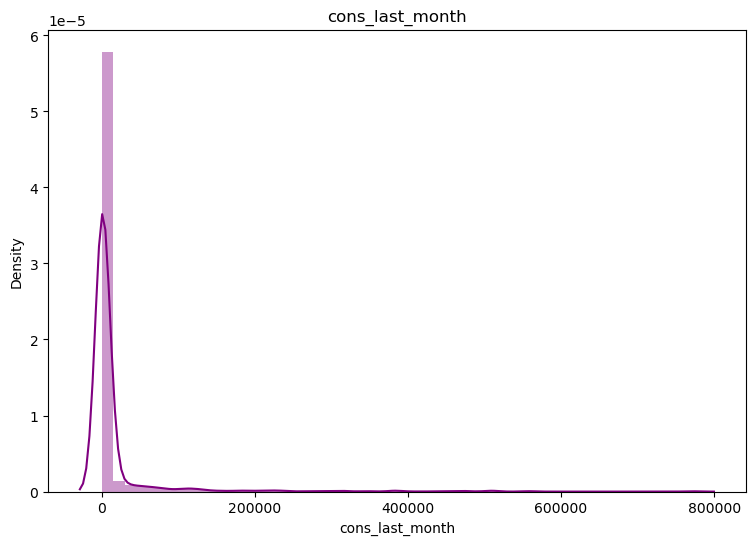

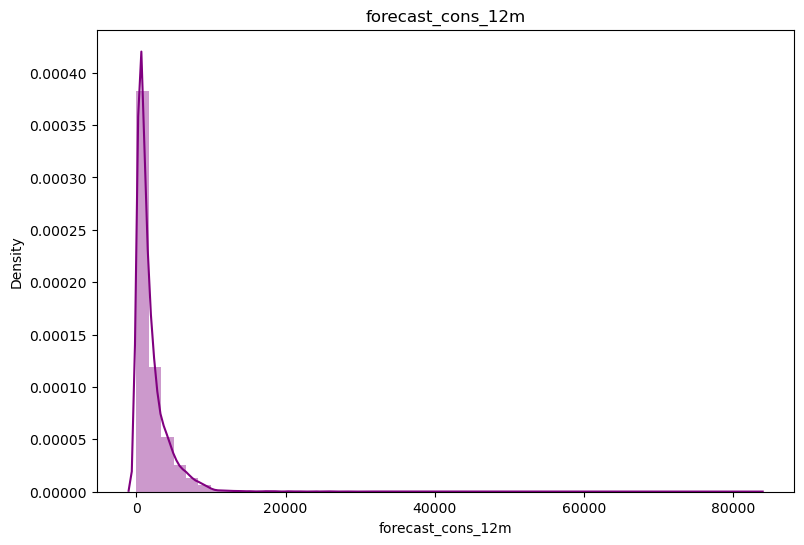

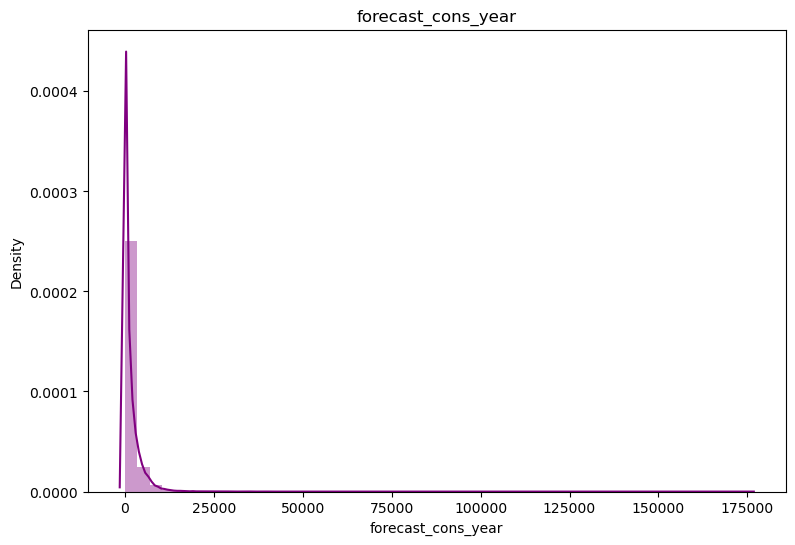

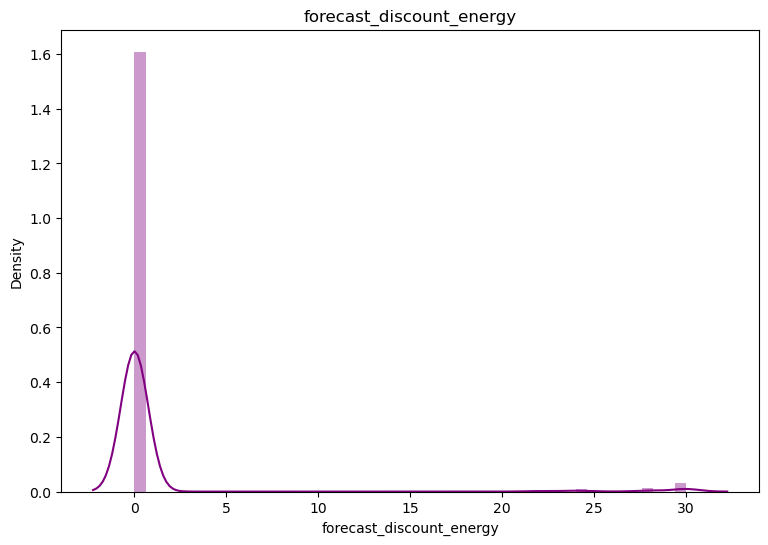

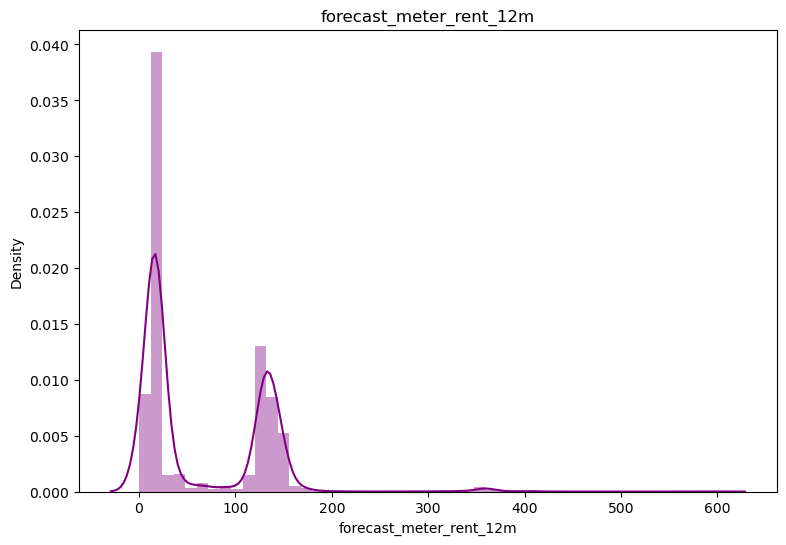

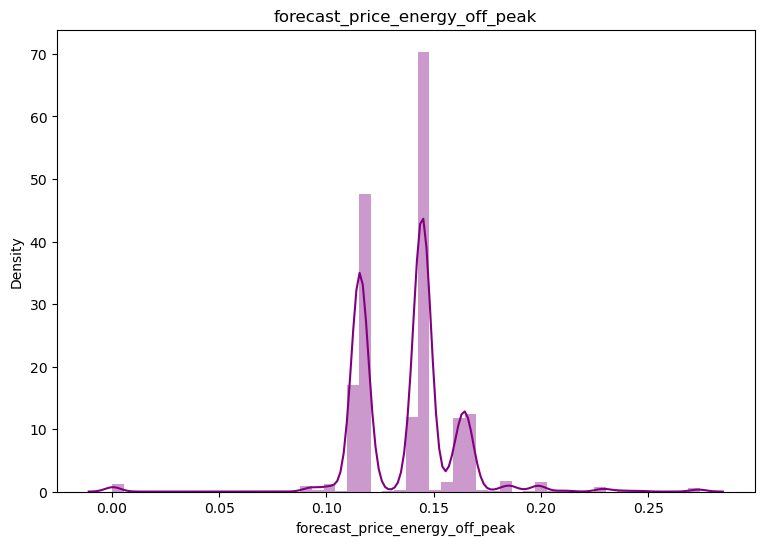

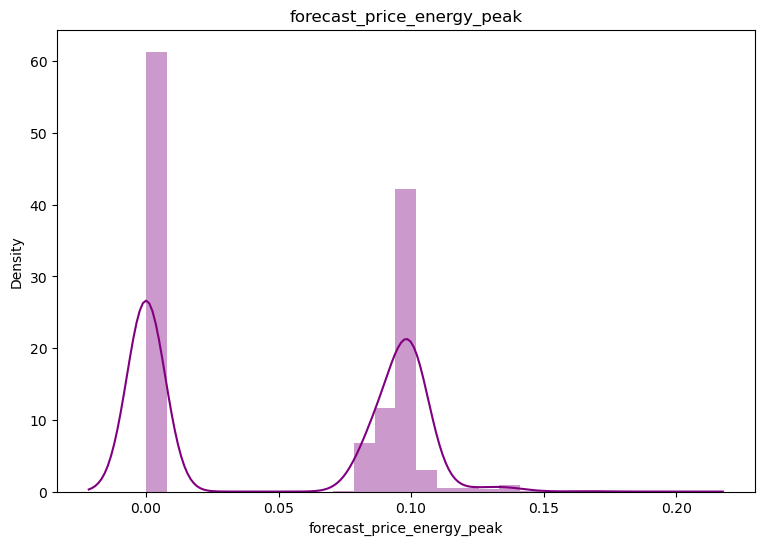

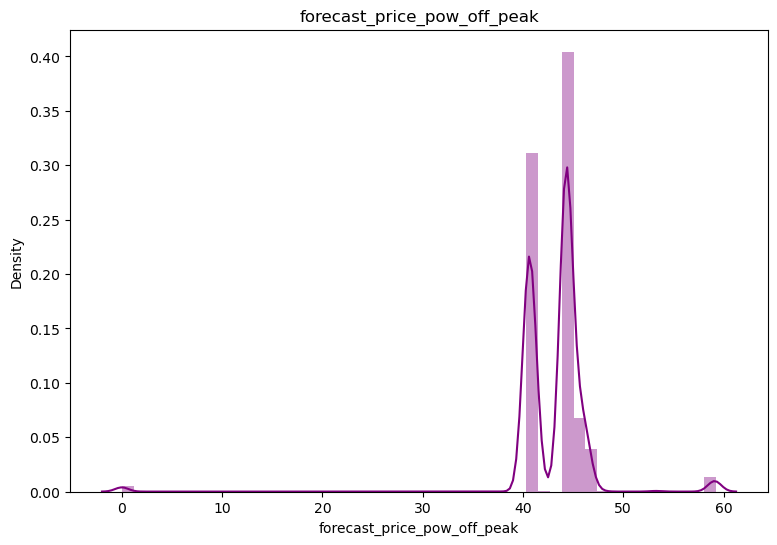

In [21]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca()
    feature = df[col]
    sns.distplot(feature, ax=ax, color="purple")
    ax.set_title(col)
plt.show()

In [22]:
for i in numeric_features:
    df[i]=df[i].apply(lambda x:np.log(1+x))

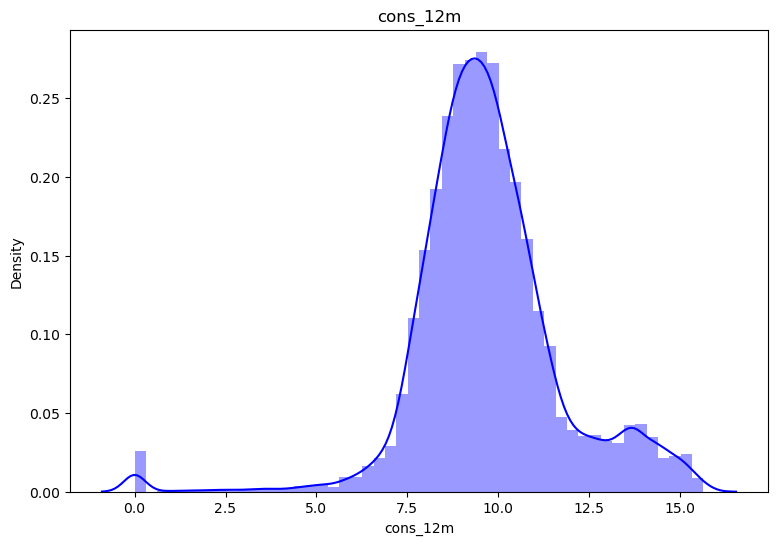

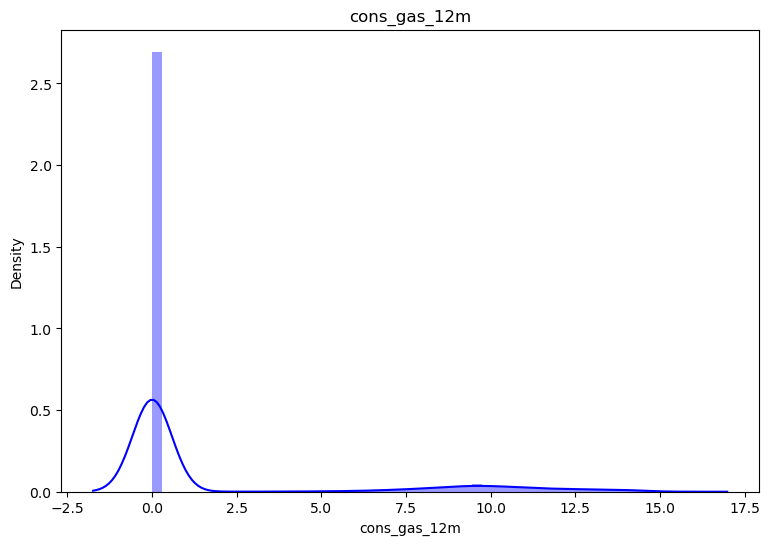

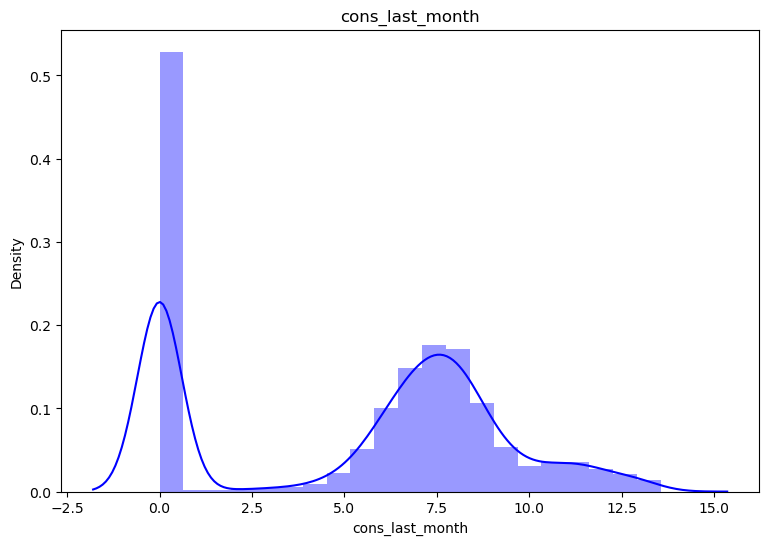

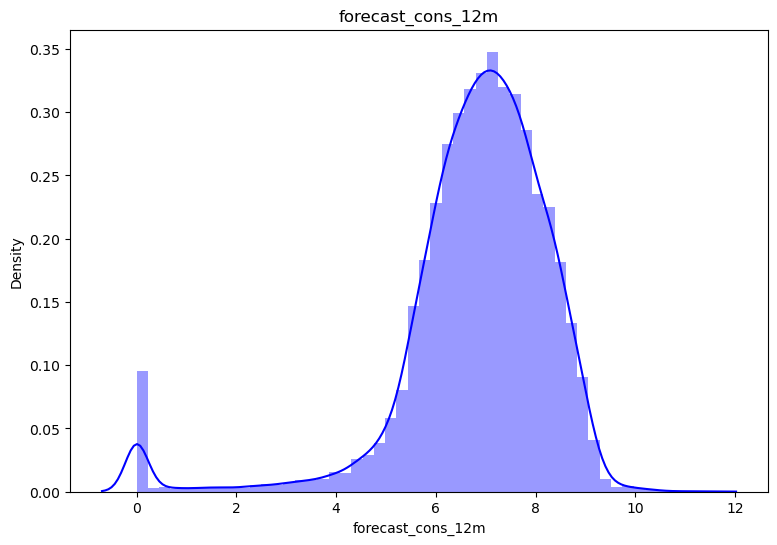

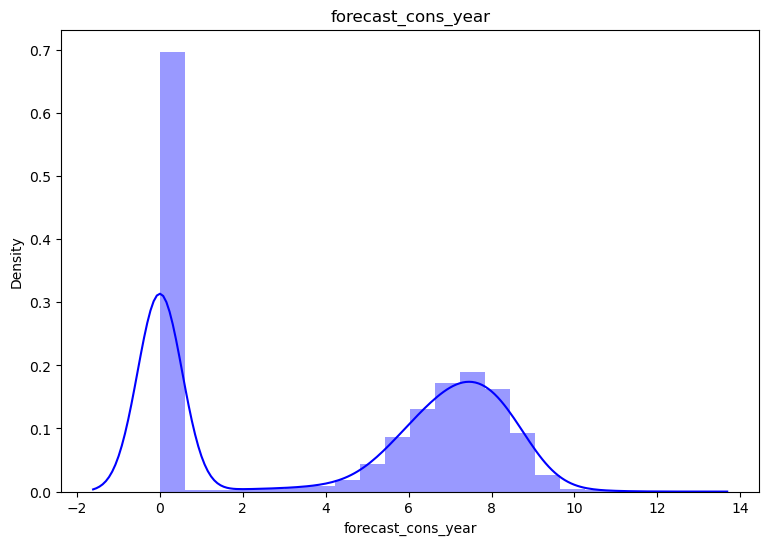

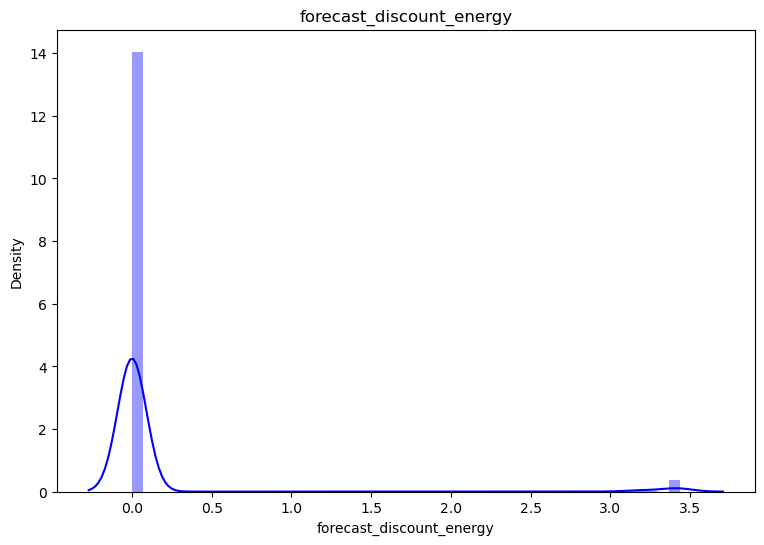

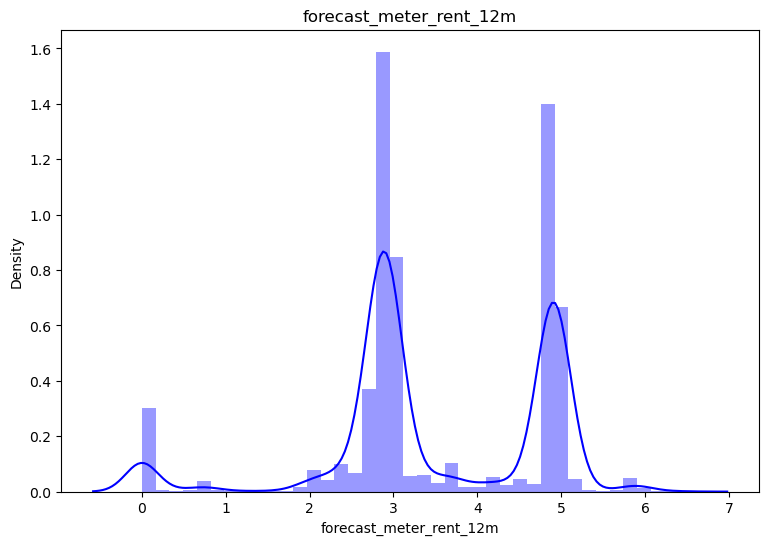

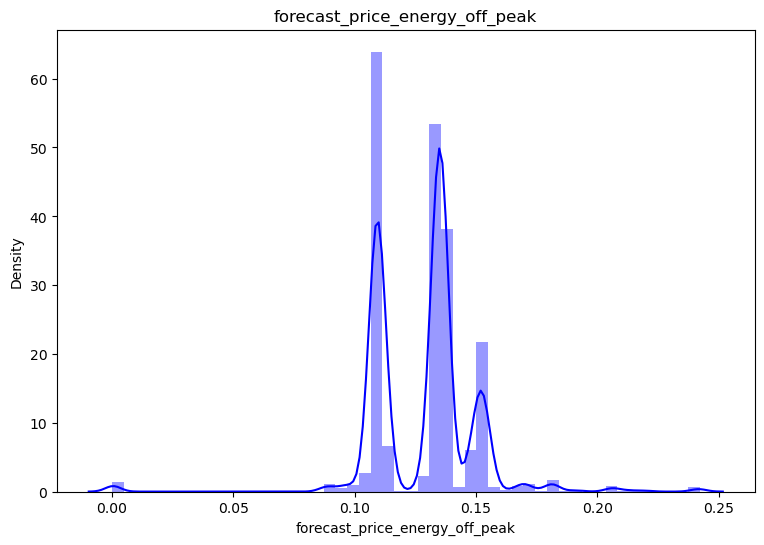

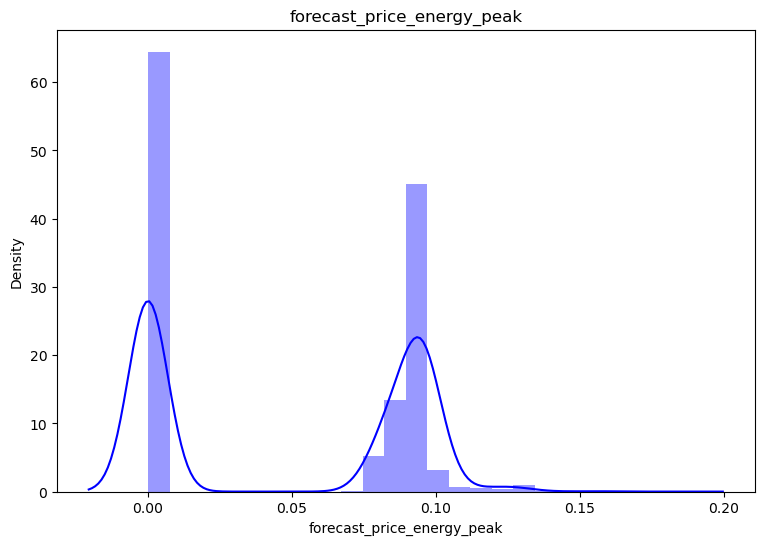

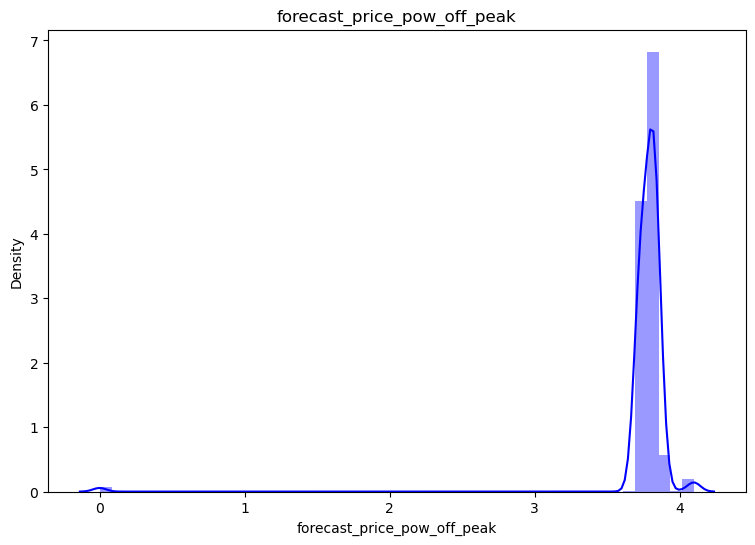

In [23]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca()
    feature = df[col]
    sns.distplot(feature, ax=ax, color="blue")
    ax.set_title(col)
plt.show()

# Correlations

In [24]:
correlation = df.corr()

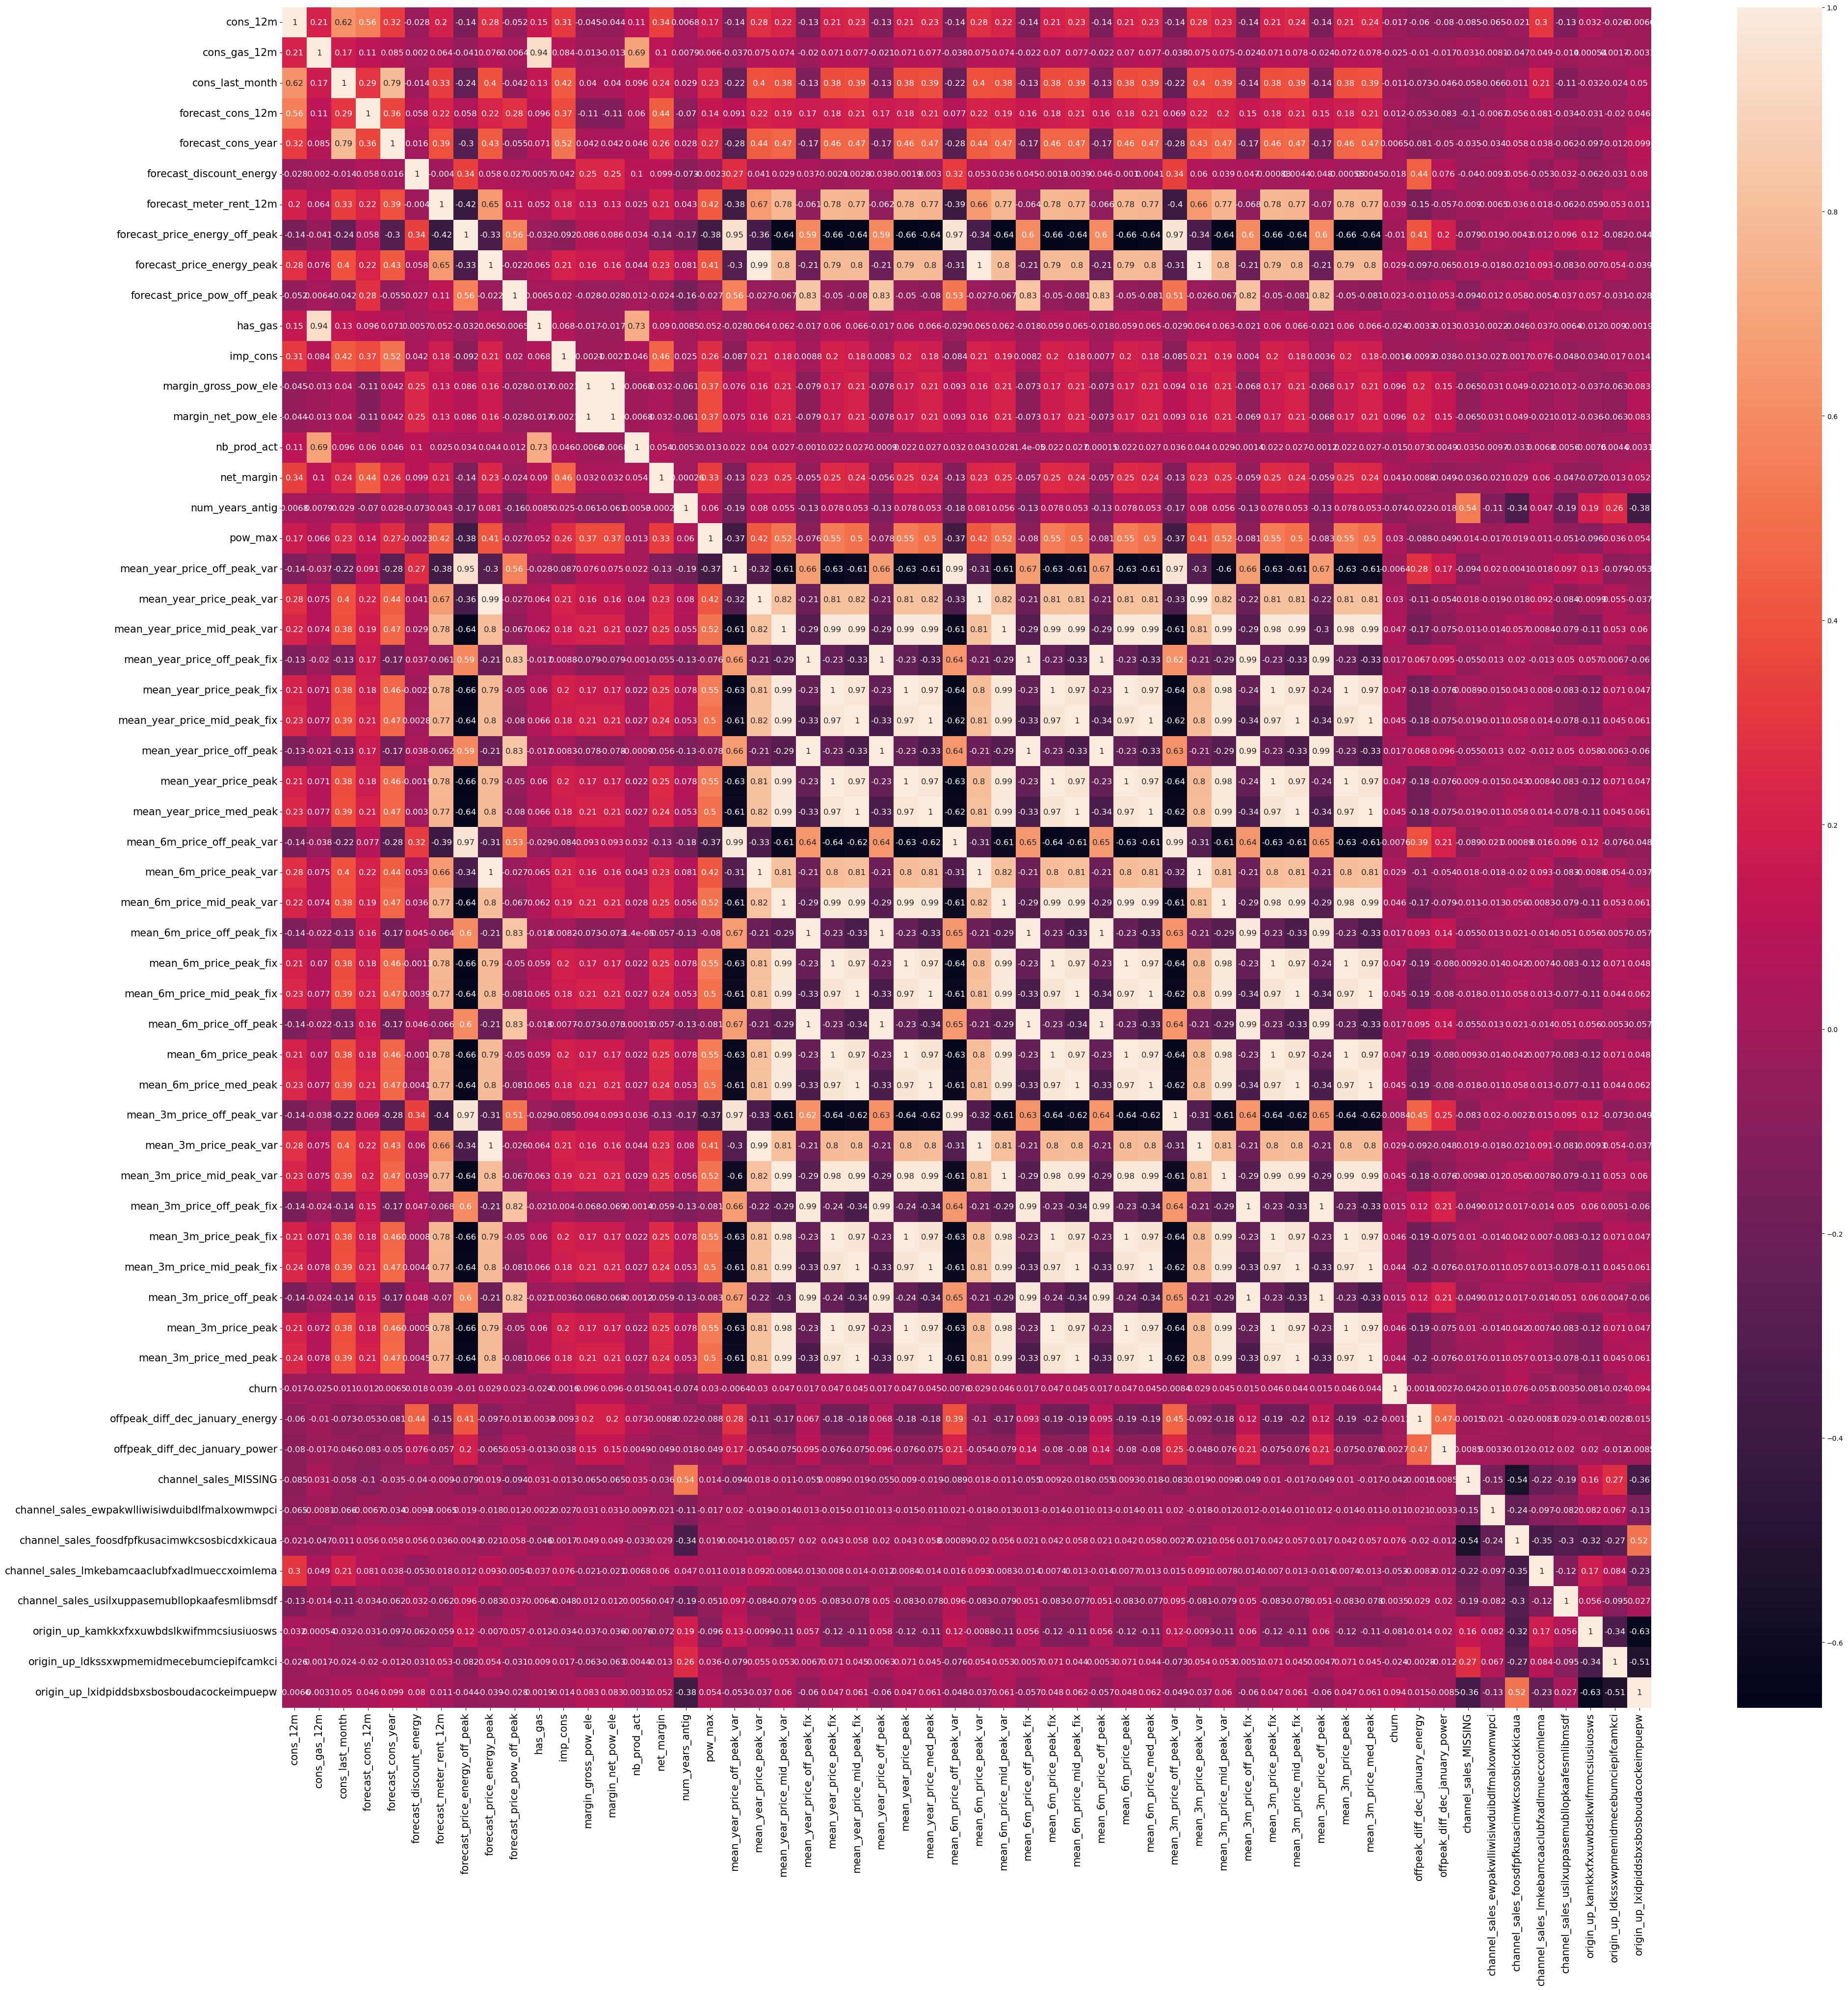

In [25]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [26]:
df = df.drop(columns=['mean_year_price_mid_peak_var', 'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix', 
                      'mean_year_price_peak', 'mean_year_price_med_peak', 'mean_6m_price_mid_peak_var', 
                      'mean_6m_price_peak_fix', 'mean_6m_price_mid_peak_fix', 'mean_6m_price_peak',
                      'mean_6m_price_med_peak', 'mean_3m_price_mid_peak_var', 'mean_3m_price_off_peak_fix', 
                      'mean_3m_price_peak_fix', 'mean_3m_price_mid_peak_fix', 'mean_3m_price_peak', 'mean_3m_price_med_peak'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,10.914124,0.000000,0.000000,0.000000,0.0,1.022451,0.108389,0.093620,...,0.020057,3.700961,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,8.446985,0.000000,0.000000,5.252012,0.000000,0.0,2.848971,0.136025,0.000000,...,-0.003767,0.177779,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,6.300786,0.000000,0.000000,3.891004,0.000000,0.0,3.681855,0.153402,0.084248,...,-0.004670,0.177779,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,7.368340,0.000000,0.000000,5.484963,0.000000,0.0,3.036394,0.136883,0.000000,...,-0.004547,0.177779,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,8.395252,0.000000,6.267201,6.101999,6.267201,0.0,4.888317,0.110557,0.095324,...,-0.006192,0.162916,1,0,0,0,0,1,0,0


# Building Prediction model

In [27]:
# Separate target variable from independent variables
X = df.drop(columns=['id', 'churn'])
y = df['churn']

In [28]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 10223
Test cases: 4382


In [29]:
y.value_counts()

0    13186
1     1419
Name: churn, dtype: int64

In [30]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE().fit_resample(X, y)

In [31]:
#check the number of target variable after oversampling using SMOTE
from collections import Counter
print('Resample dataset shape', Counter(y))

Resample dataset shape Counter({1: 13186, 0: 13186})


In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10223, 39)
(10223,)
(4382, 39)
(4382,)


# Logistic Regression

In [33]:
# Train the model
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)
print (model)

LogisticRegression(C=100.0, solver='liblinear')


In [35]:
y_pred = model.predict(X_test)

In [36]:
#Let's check the accuracy of the predictions 
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.9091738931994523


Text(113.9222222222222, 0.5, 'Actual')

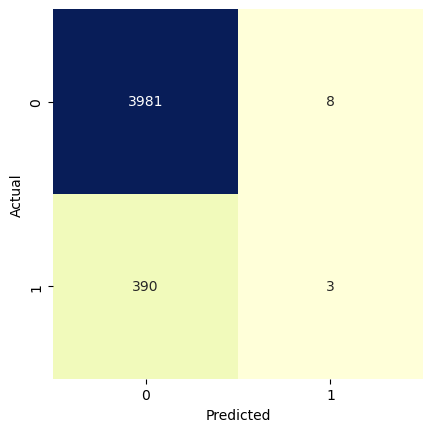

In [37]:
#create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm, square=True, annot=True, cbar=False,  cmap="YlGnBu" ,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [38]:
from sklearn import metrics
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

True positives: 3
False positives: 8
True negatives: 3981
False negatives: 390



In [39]:
from sklearn. metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3989
           1       0.27      0.01      0.01       393

    accuracy                           0.91      4382
   macro avg       0.59      0.50      0.48      4382
weighted avg       0.85      0.91      0.87      4382



In [40]:
# retrieve the precision_score and recall_score metrics
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, y_pred))
print("Overall Recall:",recall_score(y_test, y_pred))

Overall Precision: 0.2727272727272727
Overall Recall: 0.007633587786259542


In [41]:
y_scores = model.predict_proba(X_test)
print(y_scores[:10])

[[0.86451287 0.13548713]
 [0.93123841 0.06876159]
 [0.92360395 0.07639605]
 [0.91586887 0.08413113]
 [0.76663961 0.23336039]
 [0.877094   0.122906  ]
 [0.94380071 0.05619929]
 [0.93744451 0.06255549]
 [0.91152758 0.08847242]
 [0.9257378  0.0742622 ]]


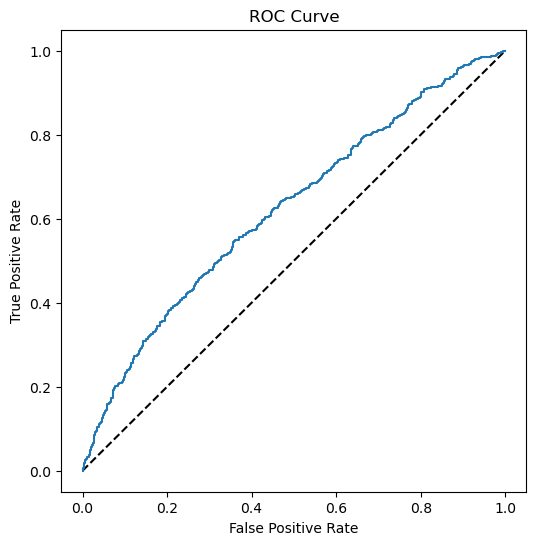

In [42]:
from sklearn.metrics import roc_curve
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [43]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.6219246694312668


# Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators = 1000).fit(X_train, (y_train))
print (model_RF)

RandomForestClassifier(n_estimators=1000)


True positives: 22
False positives: 6
True negatives: 3983
False negatives: 371

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3989
           1       0.79      0.06      0.10       393

    accuracy                           0.91      4382
   macro avg       0.85      0.53      0.53      4382
weighted avg       0.90      0.91      0.88      4382

Accuracy: 0.9139662254678229
Overall Precision: 0.7857142857142857
Overall Recall: 0.05597964376590331

AUC: 0.6784340779382488


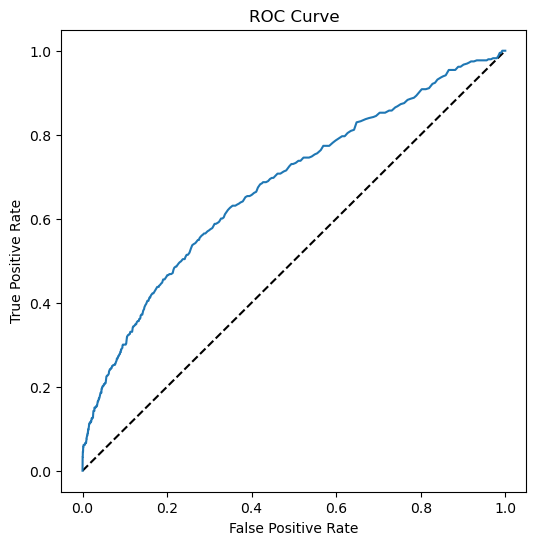

In [45]:
y_pred_RF = model_RF.predict(X_test)
y_scores_RF = model_RF.predict_proba(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_RF).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(classification_report(y_test, y_pred_RF))

print('Accuracy:', accuracy_score(y_test, y_pred_RF))
print("Overall Precision:",precision_score(y_test, y_pred_RF))
print("Overall Recall:",recall_score(y_test, y_pred_RF))
auc = roc_auc_score(y_test,y_scores_RF[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores_RF[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Model Understanding

In [46]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model_RF.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

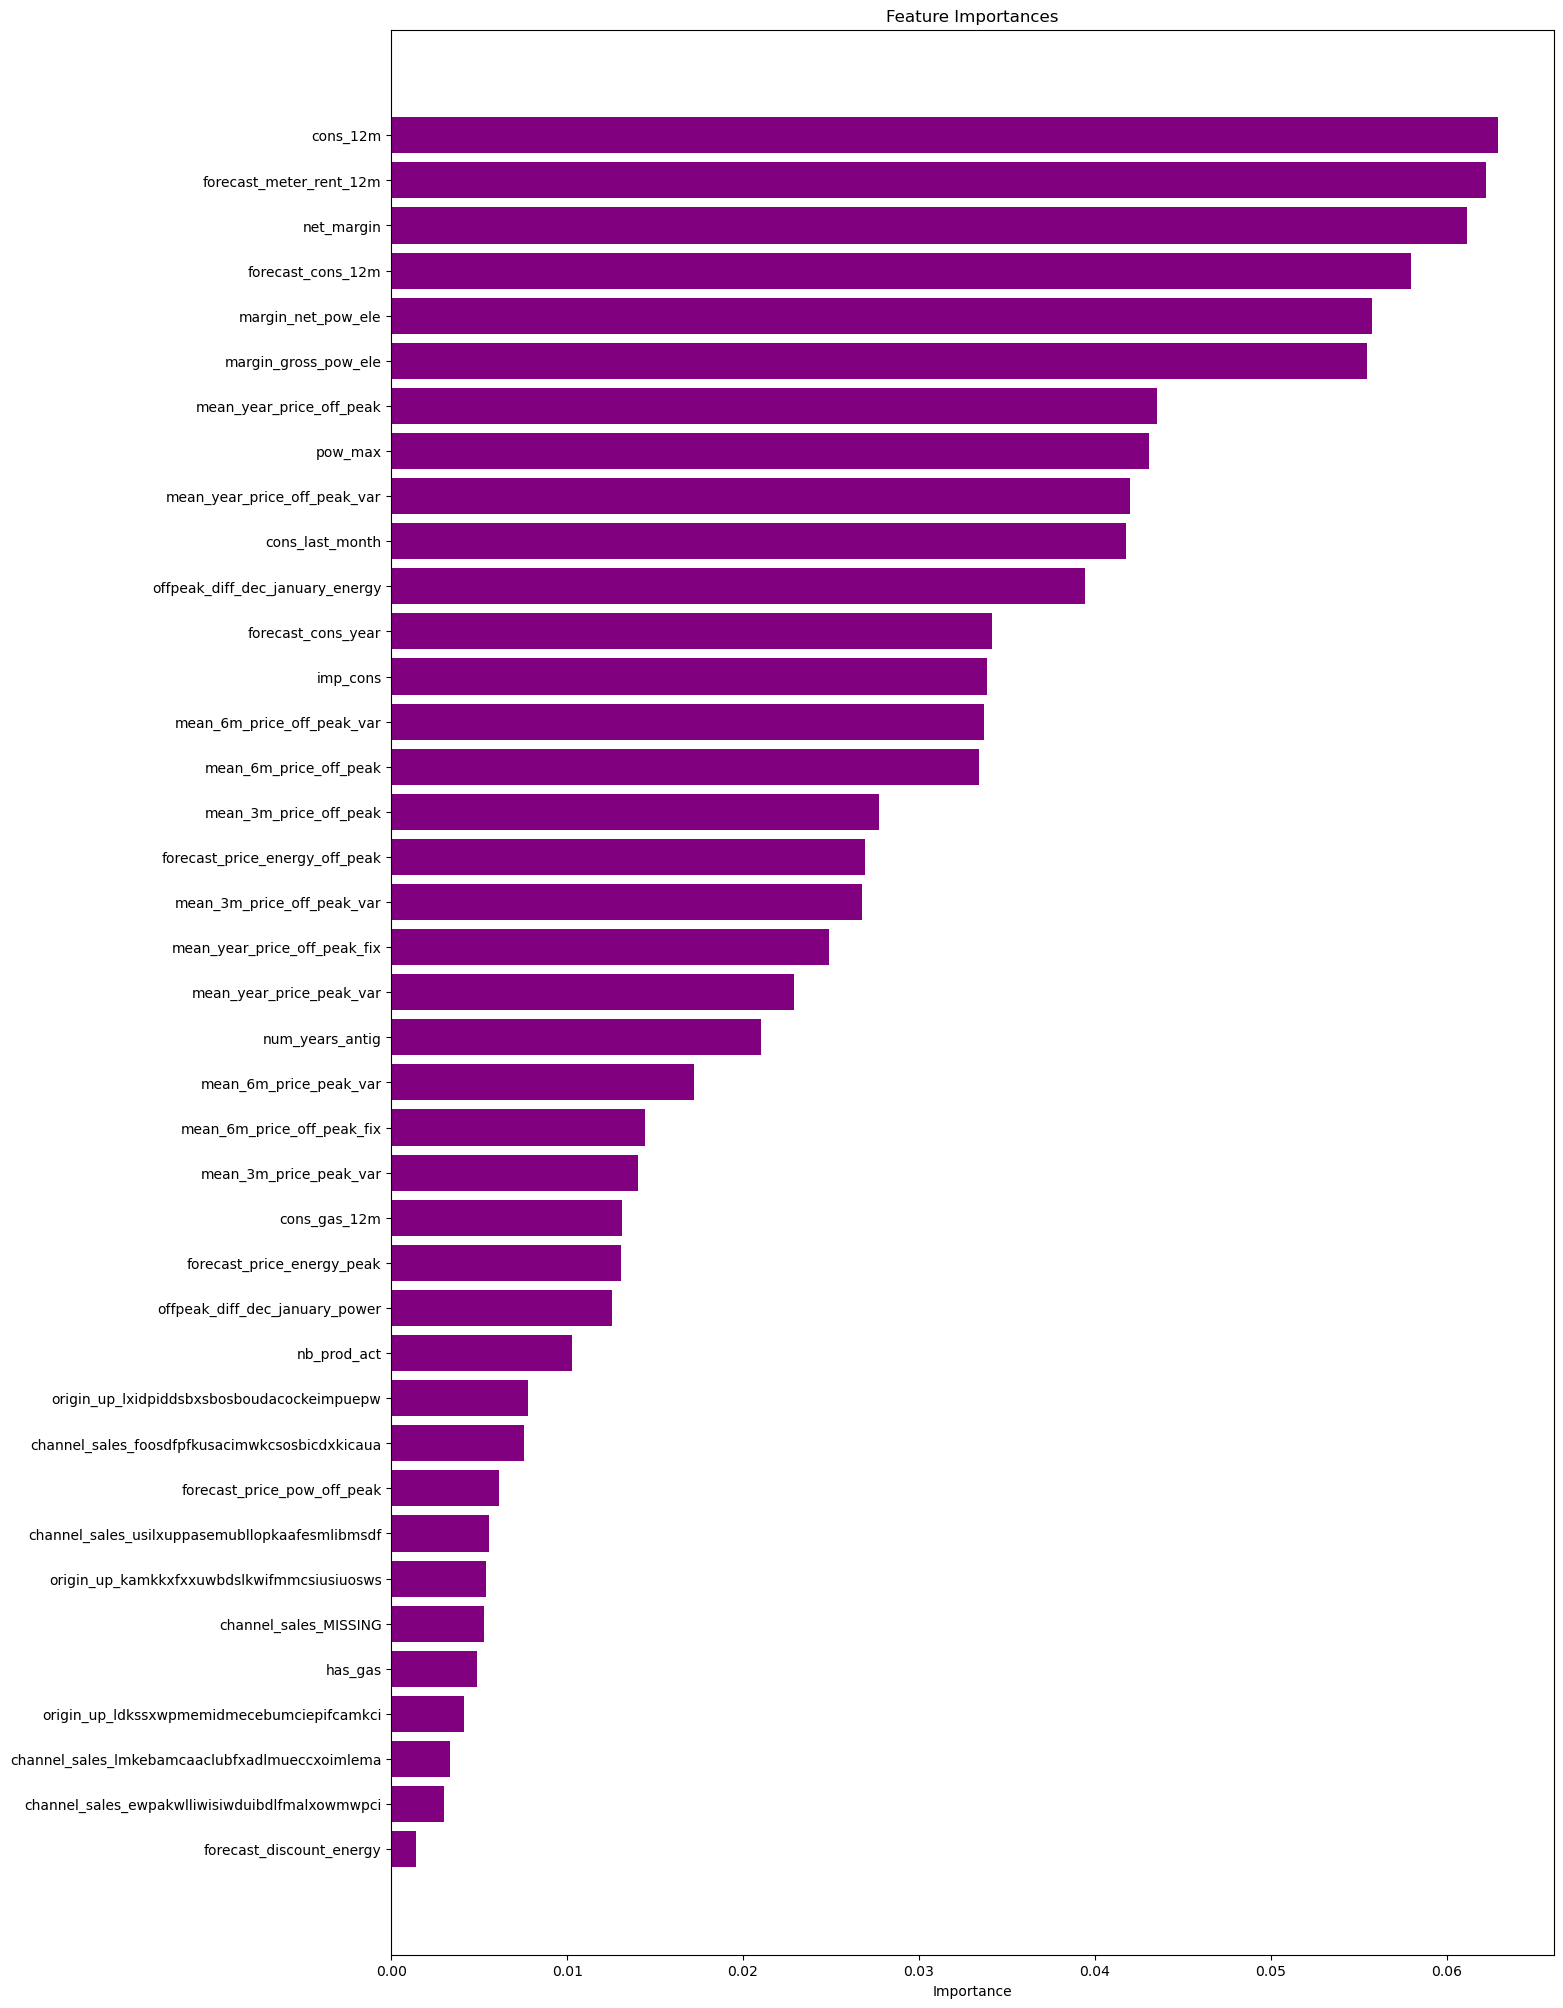

In [47]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='purple', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [48]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [49]:
y_scores = model_RF.predict_proba(X_test)
probabilities = y_scores[:, 1]

In [50]:
X_test['churn'] = y_pred_RF.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('data_with_predictions.csv')

In [51]:
import joblib

# Save the model as a pickle file
filename = 'powerco_churn_model.pkl'
joblib.dump(model_RF, filename)

['powerco_churn_model.pkl']